Thanks NASA for the dataset.(Remote Sensing)

#Problem Statement
> The dataset contains such columns as: "wind direction", "wind speed", "humidity" and temperature. The response parameter that is to be predicted is: "Solar_radiation". 

> It contains measurements for the past 4 months and you have to predict the level of solar radiation.

> Just imagine that you've got solar energy batteries and you want to know will it be reasonable to use them in future?



# <center> Demonstrating LSTM using Tensorflow & Keras
    
**In this session we will,**
- *Extract the solar radiation information from the [given dataset](https://www.kaggle.com/datasets/dronio/SolarEnergy)*
- *Use Tensorflow & Keras to implement LSTM to predict*
- *Understand how to calculate the output shape of each layer*
- *Understand how to calculate the parameters in every layer*
    
## Begining with reading the CSV file

In [ ]:
## Import pandas for reading the csv file
import pandas as pd

## Read csv file
df = pd.read_csv("/content/SolarPrediction.csv")

## Print the info of dataframe
print(df.info(), "\n")

## Display first 5 rows of data
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32686 entries, 0 to 32685
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   UNIXTime                32686 non-null  int64  
 1   Data                    32686 non-null  object 
 2   Time                    32686 non-null  object 
 3   Radiation               32686 non-null  float64
 4   Temperature             32686 non-null  int64  
 5   Pressure                32686 non-null  float64
 6   Humidity                32686 non-null  int64  
 7   WindDirection(Degrees)  32686 non-null  float64
 8   Speed                   32686 non-null  float64
 9   TimeSunRise             32686 non-null  object 
 10  TimeSunSet              32686 non-null  object 
dtypes: float64(4), int64(3), object(4)
memory usage: 2.7+ MB
None 



,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
0,1475229326,9/29/2016 12:00:00 AM,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00
1,1475229023,9/29/2016 12:00:00 AM,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00
2,1475228726,9/29/2016 12:00:00 AM,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00
3,1475228421,9/29/2016 12:00:00 AM,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00
4,1475228124,9/29/2016 12:00:00 AM,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00


- ***Note that we are just interested in the solar radiation***
- *There are no missing data present*
- *Approximately, the data is collected after every 5 minutes*
- *There are total of 1440 minutes in a day, hence approx every 1440/5 = 288 data points represents a day*  
- *Lets extract the solar radiation data*

In [ ]:
## Filter out the solar radiation data from df
solar_rad = df.filter(['Radiation'])
solar_rad = solar_rad.iloc[:32000,:]
## Convert solar rad df into a numpy array
rad_arr = solar_rad.values
print(f'Radiation Data:- \n{rad_arr}\n\nShape of radiation array:-\n{rad_arr.shape}')


Radiation Data:- 
[[  1.21]
 [  1.21]
 [  1.23]
 ...
 [147.63]
 [ 89.75]
 [158.15]]

Shape of radiation array:-
(32000, 1)


- *We have sucessfully converted solar radiation df into array*

## Visualise the Solar Radiation 

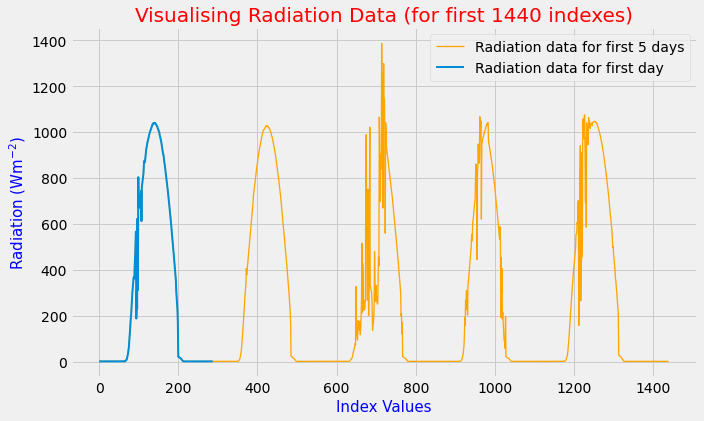

In [ ]:
## Visualise the radiation array (Univariate Analysis using Matplotlib)

# Using matplotlib
import matplotlib.pyplot as plt

# Define a function to plot till a specific data point
def rad_plot(index):                                             # index is assumed as 1440
    plt.style.use('fivethirtyeight')                             # Style variant of Matplotlib
    plt.figure(figsize = (10,6))                                 # figure size in height and width
    plt.plot(rad_arr[:index], linewidth = 1.3, c = 'orange')     # Plot for all 1440 readings
    plt.plot(rad_arr[288*0:288*1], linewidth = 2)    # Plot data for first day (288) readings
    plt.title(f'Visualising Radiation Data (for first {index} indexes)', fontsize = 20, c = 'r') # Title card
    plt.ylabel('Radiation (Wm$^{-2}$)', fontsize = 15, c = 'b')  # Y_label
    plt.xlabel('Index Values', fontsize = 15, c = 'b')           # X_label
    # index/288 = no. of days
    plt.legend((f"Radiation data for first {int(index/288)} days", "Radiation data for first day"), loc = 'best') # legends 
    plt.show()

# Plot first 1440 data points
rad_plot(1440)

- *The pattern in the data makes sesne! Rises till noon and then falls*

## Scaling the data

In [ ]:
## Scaling the values in between 0 and 1

# Using sklearn import min-max scaler
from sklearn.preprocessing import MinMaxScaler

# Minimum = 0, Maximum = 1
min, max = 0, 1

# Generate the scaler
scaler = MinMaxScaler(feature_range=(min, max))

# Scale the radiation array
scaled_data = scaler.fit_transform(rad_arr)

# Importing numpy to round the values
import numpy as np

# Display some output after scaling and print max and min values
print(f"""After scaling the radiation data in between {min} to {max}, 
Below are first ten respective scaled entries:-
-----------------------------------------------------
{scaled_data[1000:1010]}
-----------------------------------------------------
Max value:- {np.round(scaled_data.max())}
Min value:- {np.round(scaled_data.min())}""")

After scaling the radiation data in between 0 to 1, 
Below are first ten respective scaled entries:-
-----------------------------------------------------
[[0.47239321]
 [0.46095054]
 [0.45165766]
 [0.44127738]
 [0.42864106]
 [0.41553604]
 [0.40575571]
 [0.39301316]
 [0.38094554]
 [0.36919664]]
-----------------------------------------------------
Max value:- 1.0
Min value:- 0.0


- *Our data is scaled! Now we can split the data for training and testing*

## Train-Test split

In [ ]:
## Spliting the data - 80% as training and 20% as testing

# To round down the number
import math

# Training size
train_size = math.ceil(len(scaled_data) * 0.8)

# Spliting 
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

# Summary of spliting
print(f'Size of ~\nTrain Data:- {len(train_data)}\nTest Data:- {len(test_data)}')

Size of ~
Train Data:- 25600
Test Data:- 6400


#Univariate Time Series Data for Long Short-Term Memory Networks

## Initialise Sequences and Labels

*Let us try to take a smaller example to understand how we will get sequences and labels. Assume we have 10 points in our dataset, [a, b, c, d, e, f, g, h, i, j] and we want to create sequence of 3 points then how would our sequence and labels look like?*

- **First sequence:-** [a, b, c], **First label:-** [d]
- **Next sequences:-** [b, c, d], **Next labels:-** [d, e]
- **Next sequences:-** [c, d, e], **Next labels:-** [d, e, f]

*Similarly the trend will go on untill the last one and this is how we will obtain our Sequences and Labels*

In [ ]:
## Create a function to inititalise the sequences and labels
def init_seqs_labels(data, seq_len, show = True, num_seqs = 2):
    """
    data:- Train or Test Data
    seq_len:- Length of the sequences to be generated
    show:- Display the sequences and labels
    num_seqs:- How many labels to generate - 1
    """
    
    # Initialise lists for sequences and labels to append later
    seqs, labels = [], []
    
    # Iterate through dataset 
    for i in range(seq_len,len(data)):        # range(5, 25600)
        
        # Form sequences and labels
        seqs.append(data[i - (seq_len) : i, 0])
        labels.append(data[i, 0])
        
        # If user wants to display the labels and squences
        if show == True:
            
            # Show num_seq + 1 labels
            if i <= (seq_len) + num_seqs:
                print(f'Sequences of {seq_len} numbers:-\n{seqs}\n\nNext values:-\n{labels}\n\n')
    
    # Convert list to arrays to return it as the output of this function
    seqs, labels = np.array(seqs), np.array(labels)
    
    return seqs, labels

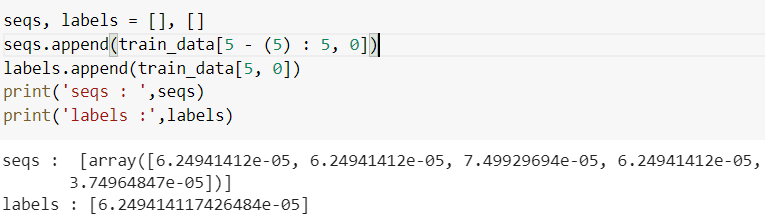

In [ ]:
## For demonstration purpose lets visualise first three labels if sequence length was 5
x, y = init_seqs_labels(train_data, 5, show = True, num_seqs = 2)

Sequences of 5 numbers:-
[array([6.24941412e-05, 6.24941412e-05, 7.49929694e-05, 6.24941412e-05,
       3.74964847e-05])]

Next values:-
[6.249414117426484e-05]


Sequences of 5 numbers:-
[array([6.24941412e-05, 6.24941412e-05, 7.49929694e-05, 6.24941412e-05,
       3.74964847e-05]), array([6.24941412e-05, 7.49929694e-05, 6.24941412e-05, 3.74964847e-05,
       6.24941412e-05])]

Next values:-
[6.249414117426484e-05, 5.6244727056838344e-05]


Sequences of 5 numbers:-
[array([6.24941412e-05, 6.24941412e-05, 7.49929694e-05, 6.24941412e-05,
       3.74964847e-05]), array([6.24941412e-05, 7.49929694e-05, 6.24941412e-05, 3.74964847e-05,
       6.24941412e-05]), array([7.49929694e-05, 6.24941412e-05, 3.74964847e-05, 6.24941412e-05,
       5.62447271e-05])]

Next values:-
[6.249414117426484e-05, 5.6244727056838344e-05, 8.124238352654432e-05]




In [ ]:
len(x)

25595

In [ ]:
len(y)

25595

## Get the sequences and labels for training and validation

In [ ]:
## Now lets get our sequences and labels for both training and testing data

# Training data
x_train, y_train = init_seqs_labels(train_data, 60, show = False)

# Testing data
x_val, y_val = init_seqs_labels(test_data, 60, show = False)

# Check for the shape
print('x_train_shape:', x_train.shape)
print('y_train_shape:',y_train.shape)
print('x_val_shape:',x_val.shape)
print('y_val_shape:',y_val.shape)


x_train_shape: (25540, 60)
y_train_shape: (25540,)
x_val_shape: (6340, 60)
y_val_shape: (6340,)


In [ ]:
x_train[0]

array([6.24941412e-05, 6.24941412e-05, 7.49929694e-05, 6.24941412e-05,
       3.74964847e-05, 6.24941412e-05, 5.62447271e-05, 8.12423835e-05,
       7.49929694e-05, 6.24941412e-05, 7.49929694e-05, 6.24941412e-05,
       6.87435553e-05, 6.24941412e-05, 7.49929694e-05, 6.87435553e-05,
       6.24941412e-05, 6.87435553e-05, 6.87435553e-05, 5.62447271e-05,
       5.62447271e-05, 5.62447271e-05, 6.24941412e-05, 6.87435553e-05,
       6.87435553e-05, 6.87435553e-05, 8.12423835e-05, 7.49929694e-05,
       7.49929694e-05, 7.49929694e-05, 8.12423835e-05, 5.62447271e-05,
       8.12423835e-05, 6.24941412e-05, 8.12423835e-05, 5.62447271e-05,
       4.99953129e-05, 8.74917976e-05, 8.74917976e-05, 7.49929694e-05,
       6.24941412e-05, 8.74917976e-05, 7.49929694e-05, 7.49929694e-05,
       9.37412118e-05, 3.74964847e-05, 6.87435553e-05, 6.87435553e-05,
       6.87435553e-05, 8.12423835e-05, 8.74917976e-05, 4.99953129e-05,
       4.99953129e-05, 7.49929694e-05, 4.99953129e-05, 7.49929694e-05,
      

In [ ]:
x_train[0].shape

(60,)

In [ ]:
x_train.ndim

2

## Reshaping for LSTM network
![](https://www.researchgate.net/profile/Sourav-Malakar/publication/350218060/figure/fig5/AS:1003675539472403@1616306304445/A-schematic-diagram-of-a-3D-array-for-LSTM.png)
- *LSTM takes a 3D input shape as (**batch size, sequences length (time step), number of features**)*
- *As we have only univariate data, that means we only have one feature, Solar Radiation*
- *Hence, we need to reshape our sequences to pass it into LSTM*

In [ ]:
## Reshaping the input
x_train, x_val = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1)), np.reshape(x_val, (x_val.shape[0], x_val.shape[1], 1))

## Check the shape again
print(f'Shapes of arrays ~\nx_train:- {x_train.shape}\nx_val:- {x_val.shape}')

Shapes of arrays ~
x_train:- (25540, 60, 1)
x_val:- (6340, 60, 1)


In [ ]:
x_train[0].shape

(60, 1)

In [ ]:
x_train[0]

array([[6.24941412e-05],
       [6.24941412e-05],
       [7.49929694e-05],
       [6.24941412e-05],
       [3.74964847e-05],
       [6.24941412e-05],
       [5.62447271e-05],
       [8.12423835e-05],
       [7.49929694e-05],
       [6.24941412e-05],
       [7.49929694e-05],
       [6.24941412e-05],
       [6.87435553e-05],
       [6.24941412e-05],
       [7.49929694e-05],
       [6.87435553e-05],
       [6.24941412e-05],
       [6.87435553e-05],
       [6.87435553e-05],
       [5.62447271e-05],
       [5.62447271e-05],
       [5.62447271e-05],
       [6.24941412e-05],
       [6.87435553e-05],
       [6.87435553e-05],
       [6.87435553e-05],
       [8.12423835e-05],
       [7.49929694e-05],
       [7.49929694e-05],
       [7.49929694e-05],
       [8.12423835e-05],
       [5.62447271e-05],
       [8.12423835e-05],
       [6.24941412e-05],
       [8.12423835e-05],
       [5.62447271e-05],
       [4.99953129e-05],
       [8.74917976e-05],
       [8.74917976e-05],
       [7.49929694e-05],


In [ ]:
x_train.ndim

3

## Build the model

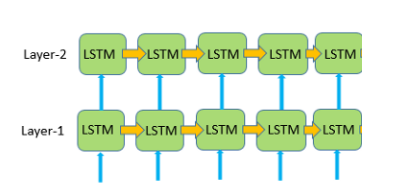

In [ ]:
# Importing Sequential model
from keras.models import Sequential

# Importing necessary layers 
from keras.layers import LSTM, Dense#, Dropout
                                    # Remove the comment above to fine tune your
                                    # model as a practice to improve the predictions


## Building the stack LSTM Model
model = Sequential([
    # LSTM(features, return_sequences = Output shape containing time steps, input_shape = (time step, features))
    # There is also an option of batch_input_shape which you can explore as part of your research work
    #Since we set return_sequences=True in the LSTM layers, the output is now a three-dimension vector.
    # If we input that into the Dense layer, it will raise an error because the Dense layer only accepts two-dimension input.
    LSTM(64, return_sequences = True, input_shape = (x_train.shape[1], x_train.shape[2])),   # input_shape = [60,1]
    
    # second LSTM layer
    LSTM(32, return_sequences = True),
    
    # Not returning sequennce this time, it will change the output shape
    # You can fine tune it later to optimise the predictions
    LSTM(16),
    
    # Adding output of LSTM network to fully connected (hidden) layers
    Dense(25),
    Dense(1)
])

## Printing the summary of the model
model.summary()    # Layer name, Output shape, Number of params

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 64)            16896     
                                                                 
 lstm_1 (LSTM)               (None, 60, 32)            12416     
                                                                 
 lstm_2 (LSTM)               (None, 16)                3136      
                                                                 
 dense (Dense)               (None, 25)                425       
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 32,899
Trainable params: 32,899
Non-trainable params: 0
_________________________________________________________________


## Output shapes - (batch size, time steps, # features)
- *As we did not provide batch size it shows None for all layers*
- *We passed 64 hidden units in first LSTM layer, hence 64 features! So output shape is:- (None, 60, 64)*
- *In second LSTM layer, there are 32 hidden units, hence output shape is:- (None, 60, 32) 
- *In third LSTM layer, we did not return the sequence but again there were 60 features, so output is:- (None, 16)*
- *Dense layer has 25 neurons, hence (None, 25)*
- *Output layer has 1 neuron, hence (None, 1)*

**Can you take a guess what might be the output if we had provided batch size?**      
*Cross check your answer while fine tuning or researching*

## Parameters Calculations - LSTM layer
![](https://miro.medium.com/max/1400/1*Ht2-sUJHi65wDwnR276k3A.png)
**Consider this above image with 2 hidden units (features) and 3 input units**
- *There are total of 4 Feed Forward Neural Net (FFNN) inside each LSTM unit*
- *Basic parameters calculation of layers involve:- total inputs * hidden neurons + biases*
- *Each LSTM unit has inputs from previous hidden layer + inputs from current layer*
- *In this example, we have total inputs of 2 hidden units + 3 input units = 5*
- *Number of biases = Number of features/hidden unit added = 2*
- *As there are total of 4 FFNN, number of parameters in each LSTM unit will be,*
    - Total params in LSTM = 4((total inputs) x hidden units + biases)
    - Total params in LSTM = 4(5 x 2 + 2) = 48

**Similarly, now calculate manually the number of params in each layer of our model**
- *LSTM - 1: 64 hidden units, 1 input units, 64 biases*
    - 4((64+1) x 64 + 64) = 16896
- *LSTM - 2: 32 hidden units, 64 input units, 32 biases*
    - 4((32+64) x 32 + 32) = 12416
-  LSTM-3: 16 hidden units,  32 input units, 16 biases
    - 4((16 + 32) x 16 + 16) = 3136
- *Dense - 1: 25 hidden units, 16 input units, 25 biases*
    - 16 x 25 + 25 = 1275
- *Output: 1 hidden units, 25 input units, 1 biases*
    - 25 x 1  + 1 = 26

## Compile and Train the model

In [ ]:
## Compiling the model
model.compile(optimizer = 'adam', loss = 'mse')    # using mean squared error as loss function 
                                                   # using adam optimiser

## Training the model
history = model.fit(x_train, y_train, epochs = 10, validation_data = (x_val, y_val))

Epoch 1/10
799/799 [==============================] - 89s 104ms/step - loss: 0.0046 - val_loss: 0.0018
Epoch 2/10
799/799 [==============================] - 69s 86ms/step - loss: 0.0033 - val_loss: 0.0015
Epoch 3/10
799/799 [==============================] - 71s 89ms/step - loss: 0.0030 - val_loss: 0.0013
Epoch 4/10
799/799 [==============================] - 68s 85ms/step - loss: 0.0030 - val_loss: 0.0012
Epoch 5/10
799/799 [==============================] - 65s 82ms/step - loss: 0.0029 - val_loss: 0.0012
Epoch 6/10
799/799 [==============================] - 66s 82ms/step - loss: 0.0029 - val_loss: 0.0014
Epoch 7/10
799/799 [==============================] - 66s 82ms/step - loss: 0.0028 - val_loss: 0.0012
Epoch 8/10
799/799 [==============================] - 65s 82ms/step - loss: 0.0028 - val_loss: 0.0012
Epoch 9/10
799/799 [==============================] - 65s 82ms/step - loss: 0.0028 - val_loss: 0.0013
Epoch 10/10
799/799 [==============================] - 65s 82ms/step - loss: 0.00

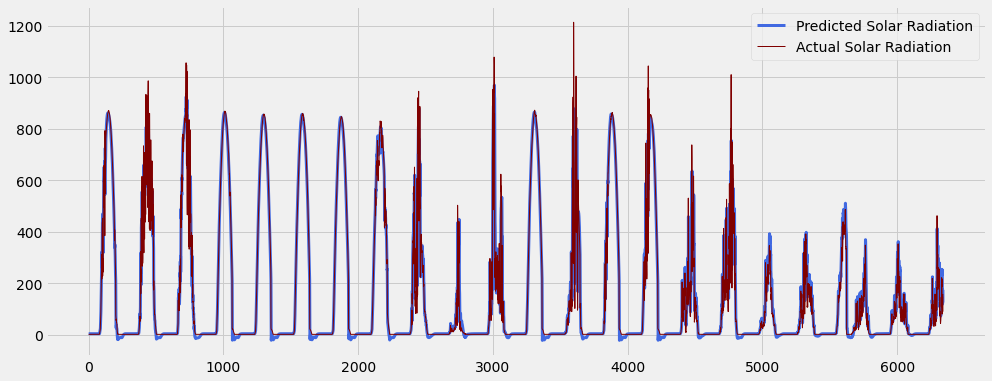

In [ ]:
## Predict the solar radiation for test/validation dataset
y_cap = model.predict(x_val)

## Scale the values back to original one
y_cap = scaler.inverse_transform(y_cap)
y_val = scaler.inverse_transform(y_val.reshape(len(y_val),1))

plt.figure(figsize = (15,6))
plt.plot(y_cap, linewidth = 3, color = 'royalblue')
plt.plot(y_val, linewidth = 1, color = 'maroon')
plt.legend(("Predicted Solar Radiation", "Actual Solar Radiation"))

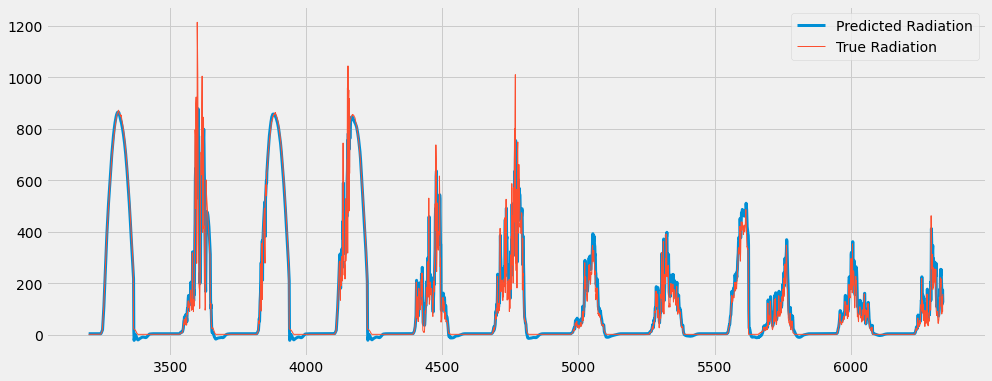

In [ ]:
plt.figure(figsize=(15,6))
x = np.arange(3200,len(y_cap))
plt.plot(x,y_cap[3200:],label='Predicted Radiation', linewidth = 3)
plt.plot(x,y_val[3200:],label="True Radiation", linewidth = 1)
plt.legend()

In [ ]:
rmse = np.sqrt(np.mean((y_cap - y_val)**2))
rmse

55.03748659726434